In [1]:
from utils.binaries import *
from utils.plotting import *

from scipy.optimize import curve_fit
from scipy.special import expit
from scipy.integrate import quad
from scipy.stats import landau


20:33:38 (  +877ms) [INFO   ] -- import logging
20:33:39 (  +164ms) [INFO   ] -- import numpy as np
20:33:39 (   +11ms) [INFO   ] -- import uncertainties
20:33:39 (  +374ms) [INFO   ] -- import pandas as pd
20:33:39 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
20:33:39 (    +2ms) [INFO   ] -- import binaries.tools as tools
20:33:39 (  +399ms) [INFO   ] -- import matplotlib.pyplot as plt
20:33:40 (  +542ms) [INFO   ] -- import seaborn as so
20:33:40 (    +3ms) [INFO   ] -- set MONI_PATH = PosixPath('/cr/work/filip/monit_and_sd')
20:33:40 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/cr/work/filip/monit_and_sd')
20:33:40 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/cr/data01/filip/plots')
20:33:40 (    +1ms) [INFO   ] -- set DATA_PATH = PosixPath('/cr/data01/filip/Data')
20:33:40 (    +0ms) [INFO   ] -- set SCAN_PATH = PosixPath('/cr/data01/filip/xy-calibration')
20:33:40 (    +1ms) [INFO   ] -- set OFLN_PATH = PosixPath('/cr/data01/filip/offline/insta

Text(0.5, 0, '$I^\\mathrm{SSD}_\\mathrm{histo}$')

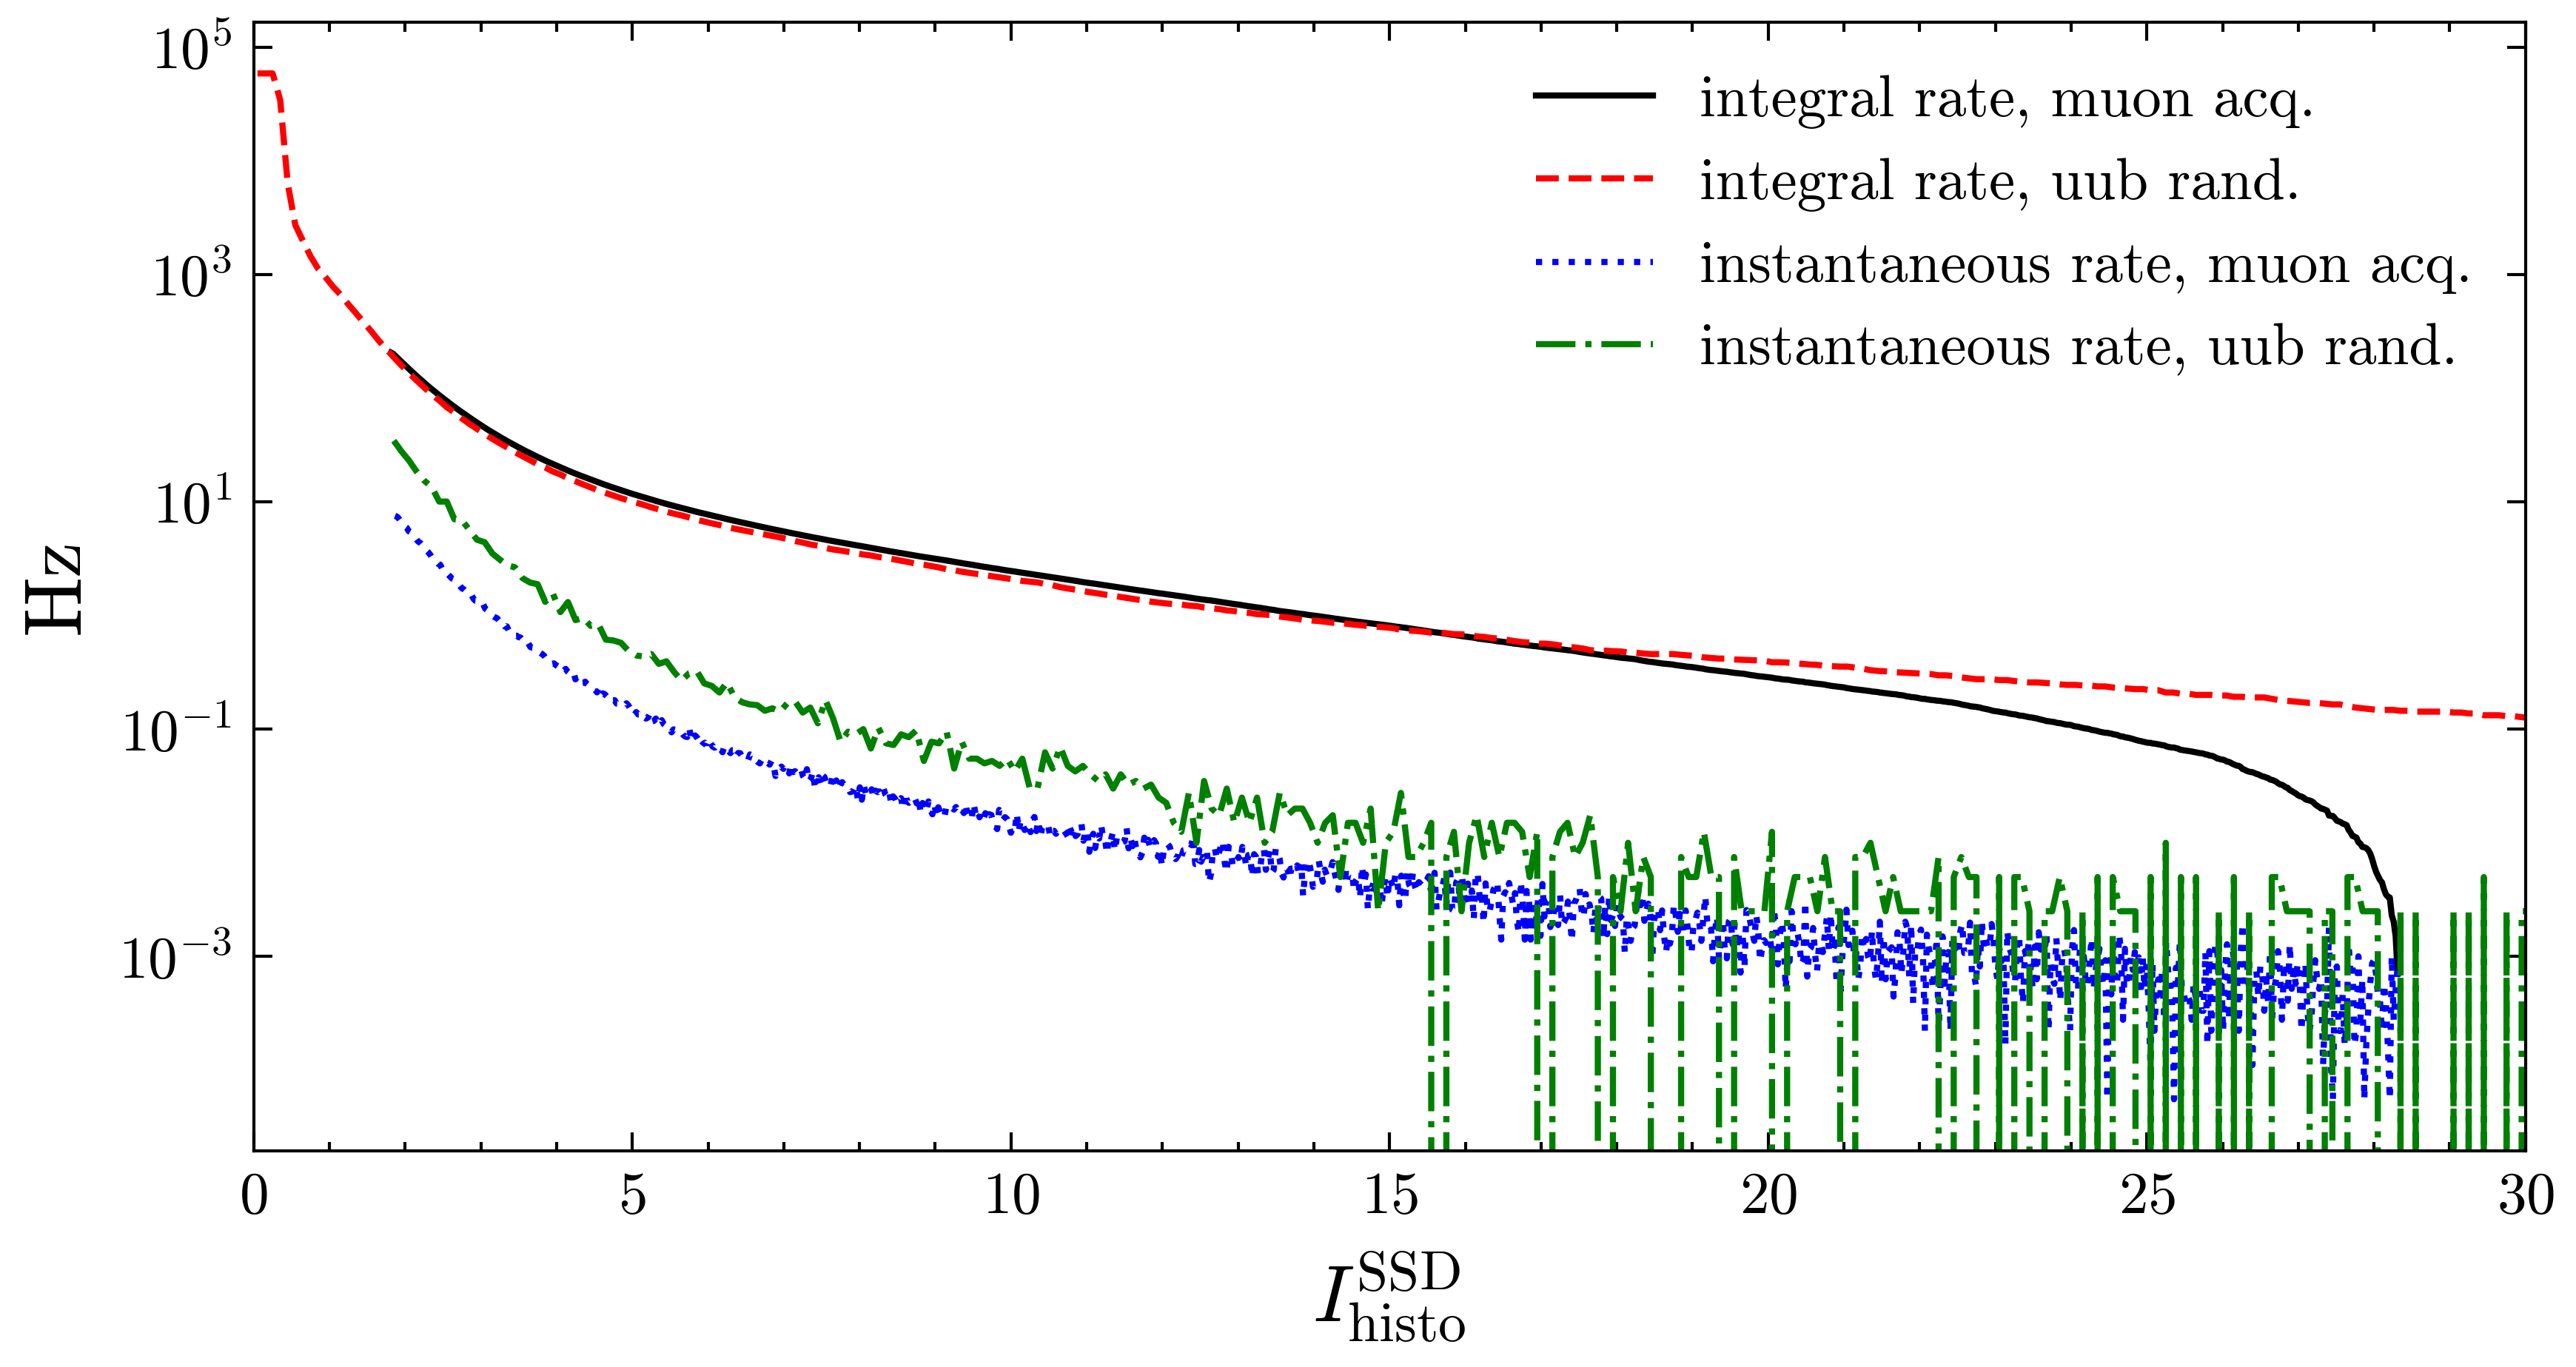

In [2]:
x, y = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
# obj = tools.pickle_load('pulse_height_distribution.pkl')[0]
x_rand, y_rand, y_err = tools.pickle_load(f'pulse_heights_randoms.pkl')
y_rand = np.cumsum(y_rand[::-1])[::-1]

inst_y = -np.diff(y[1:])
inst_y_rand = -np.diff(y_rand[1:])

def llandau(x, norm, loc, scale, suppression, cutoff):
    return norm * landau(loc, scale).pdf(x) * (1 - expit((x-cutoff)*suppression))

popt, pcov = curve_fit(llandau, x[2:], inst_y,
                       bounds=([0, 0, 0, 0, 0],[np.inf, np.inf, np.inf, np.inf, np.inf]),
                       p0=[31.88461781, 1.71248985, 0.34490904, 0., 0],
                       sigma=np.sqrt(inst_y/60))

plt.plot(x, y, label='integral rate, muon acq.')
plt.plot(x_rand, y_rand, label='integral rate, uub rand.', marker='none')
plt.plot(x[2:], inst_y, label='instantaneous rate, muon acq.', marker='none')
plt.plot(x_rand[18:], inst_y_rand[16:], label='instantaneous rate, uub rand.', marker='none')
# plt.plot(x[2:], llandau(x[2:], *popt), label='instantaneous fit', marker='none')
# plt.plot(x[2:], int_fit(x[2:]), label='fit integral', marker='none')

plt.legend()
plt.xlim(0, 30)
plt.ylabel("Hz")
plt.yscale('log')
plt.xlabel("$I^\mathrm{SSD}_\mathrm{histo}$")

In [3]:
# from data

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
mip, rate = np.loadtxt('mean_rates_t3_mip.txt', unpack=True)
i_ssd, inst_rate = mip[2:], -np.diff(rate[1:])

n_repeat = 15

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {t_70/2.64-1:.2f})")

after t_cal = 60 s, rate was 67.05 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.22 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 70.61 Hz and threshold will be 2.68 (= 0.01)
after t_cal = 61 s, rate was 66.66 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 65.56 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 69.49 Hz and threshold will be 2.62 (= -0.01)
after t_cal = 61 s, rate was 70.46 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 71.51 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 69.90 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 69.87 Hz and threshold will be 2.62 (= -0.01)
after t_cal = 61 s, rate was 73.07 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 72.31 Hz and threshold will be 2.66 (= 0.01)
after t_cal = 61 s, rate was 68.38 Hz and threshold will be 2.64 (= -0.00)
after t_cal = 61 s, rate was 7

In [4]:
# from randoms

t_cal = 10
t_70 = 50 / 48.94       # real world values
adjust = 0.2 / 48.94    # maybe this has an influence?
i_ssd, inst_rate = x_rand[18:], inst_y_rand[16:]
n_repeat = 15

while t_cal <= 60 or n_repeat:


    # create events
    peaks = np.array([])
    for x, y in zip(i_ssd, inst_rate):
        peaks = np.append(peaks, [x] * np.random.poisson(y * t_cal))
    
    # calculate trigger rate
    n_above = sum(peaks >= t_70)
    trigger_rate = n_above / t_cal
    sigma = np.sqrt(trigger_rate)
    delta = trigger_rate - 70

    match delta:
        case _ if np.abs(delta) < sigma:
            adjust -= 0.01 / 48.94
            t_cal += 5
        
        case _ if np.abs(delta) < 5:
            adjust = 0.1 / 48.94

        case _ if np.abs(delta) < 20:
            pass
        
        case _:
            adjust = 1.0 / 48.94
            t_cal = 10

    t_cal = min([61, np.max([10, t_cal])])
    adjust = min([1. / 48.94, np.max([0.01 / 48.94, t_cal])])

    if delta > 0: t_70 += adjust
    else:         t_70 -= adjust

    if t_cal >= 60: 
        n_repeat -= 1
        
        print(f"after {t_cal = } s, rate was {trigger_rate:.2f} Hz and threshold will be {t_70:.2f} (= {(t_70 - 2.64)/t_70:.2f})")

after t_cal = 60 s, rate was 76.24 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 69.10 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 76.90 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 67.15 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 75.66 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 68.26 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 80.48 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 68.15 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 79.03 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 68.08 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 79.25 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate was 67.41 Hz and threshold will be 2.53 (= -0.04)
after t_cal = 61 s, rate was 79.56 Hz and threshold will be 2.55 (= -0.03)
after t_cal = 61 s, rate 